# Time Series of Price Anomaly Detection with LSTM Autoencoders (Keras)

Autoencoders are an unsupervised learning technique in which we leverage neural networks for the task of representation learning. Specifically, it's a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input. The goal is to minimize reconstruction error based on a loss function, such as the mean squared error. <br>

The output of the model at the bottleneck is a fixed length vector that provides a compressed representation of the input data.
https://machinelearningmastery.com/lstm-autoencoders/

The steps we will follow to detect anomalies in GE stock price data using an LSTM autoencoder:
1. Train an LSTM autoencoder on GE’s stock price data from 1985–01–07 to 2013–09–03. We assume that there were no anomalies and they were normal.
2. Using the LSTM autoencoder to reconstruct the error on the test data from 2013–09–04 to 2020–09–06.
3. If the reconstruction error for the test data is above the threshold, we label the data point as an anomaly.

In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

np.random.seed(1) # keras gets its source of randomness from the NumPy random number generator, for reproducible results
tf.random.set_seed(1)

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Flatten

### The Data

In [20]:
df = pd.read_csv('data/GE.csv')
df = df[['Date', 'Close']]
print(df['Date'])
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

0       1985-01-07
1       1985-01-08
2       1985-01-09
3       1985-01-10
4       1985-01-11
           ...    
9070    2020-12-30
9071    2020-12-31
9072    2021-01-04
9073    2021-01-05
9074    2021-01-06
Name: Date, Length: 9075, dtype: object


(Timestamp('1985-01-07 00:00:00'), Timestamp('2021-01-06 00:00:00'))

### Visualize the Timeseries

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='General Electric Stock Price 1985-2020')
fig.show()

### Preprocessing: Train Test Split

In [22]:
train, test = df.loc[df['Date'] <= '2013-09-03'], df.loc[df['Date'] > '2013-09-03']
train.shape, test.shape

((7226, 2), (1849, 2))

### Standardize the data

In [23]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

C:\Users\tarek\AppData\Local\Continuum\anaconda3\envs\tf-gpu-new\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tarek\AppData\Local\Continuum\anaconda3\envs\tf-gpu-new\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Create Sequences
Convert input data into 3-D array combining TIME_STEPS. The shape of the array should be [samples, TIME_STEPS, features], as required for LSTM network.
We want our network to have memory of 30 days, so we set TIME_STEPS=30.

In [24]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

In [25]:
print(f'X Training shape: {X_train.shape}')
print(f'X Testing shape: {X_test.shape}')
print('\n')
print(f'Y Training shape: {y_train.shape}')
print(f'Y Testing shape: {y_test.shape}')

X Training shape: (7196, 30, 1)
X Testing shape: (1819, 30, 1)


Y Training shape: (7196,)
Y Testing shape: (1819,)


In [26]:
print(train[['Close']])
type(train[['Close']])

         Close
0    -1.234648
1    -1.234281
2    -1.232442
3    -1.228397
4    -1.230603
...        ...
7221  0.235430
7222  0.236842
7223  0.230488
7224  0.232606
7225  0.226957

[7226 rows x 1 columns]


pandas.core.frame.DataFrame

In [27]:
print(train['Close'])
type(train['Close'])

0      -1.234648
1      -1.234281
2      -1.232442
3      -1.228397
4      -1.230603
          ...   
7221    0.235430
7222    0.236842
7223    0.230488
7224    0.232606
7225    0.226957
Name: Close, Length: 7226, dtype: float64


pandas.core.series.Series

### Build the Model
* We define the reconstruction LSTM Autoencoder architecture that expects input sequences with 30 time steps and one feature and outputs a sequence with 30 time steps and one feature. [TIME_STEPS, features]
* RepeatVector() repeats the inputs 30 times.
* Set return_sequences=True, so the output will still be a sequence.
* TimeDistributed(Dense(X_train.shape[2])) is added at the end to get the output, where X_train.shape[2] is the number of features in the input data.
https://datascience.stackexchange.com/questions/46491/what-is-the-job-of-repeatvector-and-timedistributed

In [28]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1])) #Repeats the input n times, as we want the output shape to be (30,1)
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2]))) #applies a specific layer such as Dense to every sample it receives as an input. 
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

### Train the Model

In [29]:
history = model.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Train on 6476 samples, validate on 720 samples
Epoch 1/100
6476/6476 [==============================] - 29s 4ms/step - loss: 0.1585 - val_loss: 0.0753
Epoch 2/100
6476/6476 [==============================] - 28s 4ms/step - loss: 0.1083 - val_loss: 0.0559
Epoch 3/100
6476/6476 [==============================] - 29s 4ms/step - loss: 0.1046 - val_loss: 0.0587
Epoch 4/100
6476/6476 [==============================] - 29s 5ms/step - loss: 0.0968 - val_loss: 0.0569
Epoch 5/100
6476/6476 [==============================] - 28s 4ms/step - loss: 0.0955 - val_loss: 0.0596


### Visualize Model Training Loss

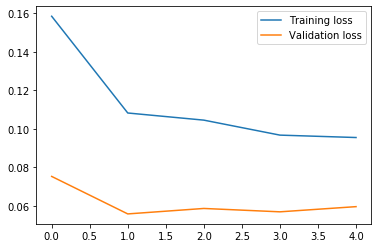

In [30]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

### Model Evaluation

In [31]:
model.evaluate(X_test, X_test)

1819/1819 [==============================] - 3s 2ms/step


0.0939782911879863

### Determine Anomalies

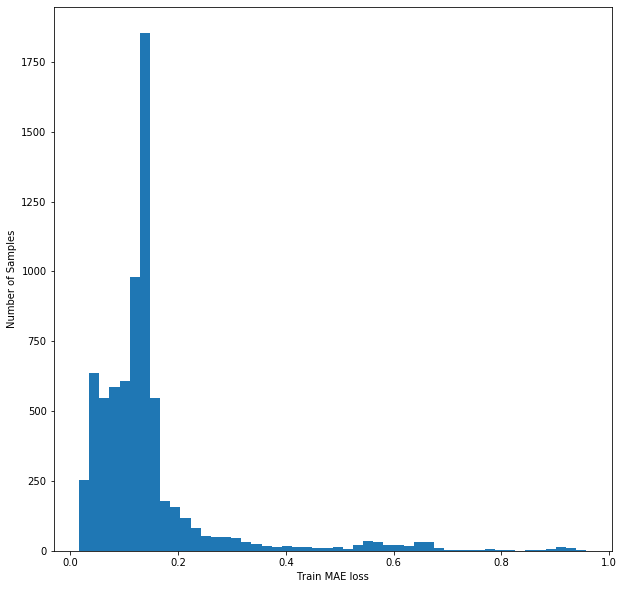

Reconstruction error threshold: 0.1769404313386697


In [45]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.figure(figsize=(10,10))
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');
plt.show()

threshold = np.percentile(train_mae_loss,85) #We can't assume that all training data is normal, otherwise model is flawed
print(f'Reconstruction error threshold: {threshold}')

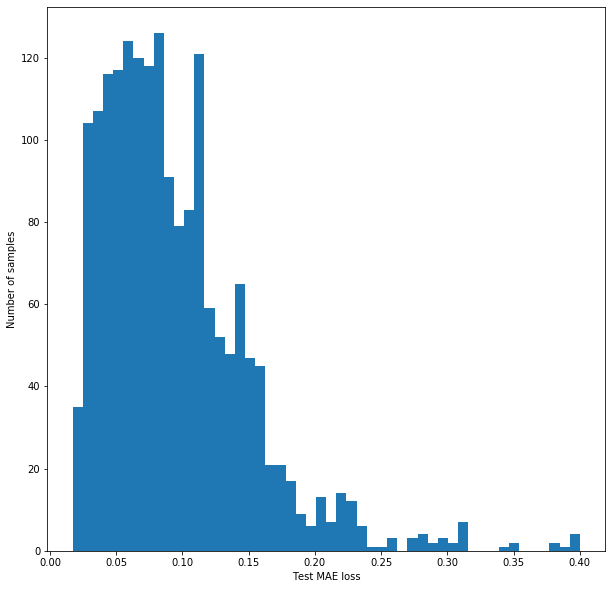

In [46]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.figure(figsize=(10,10))
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');
plt.show()

In [47]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [48]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(121, 5)

### Visualize Anomalies

In [49]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=scaler.inverse_transform(test_score_df['Close']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()